# 1a)  Goal of this project:
The end goal of this project is to use the available Enron dataset and build a Machine learning model that could classify whether a person is a Person of Interest (POI) or not. Here the POI refers to the individual who were tried for fraud or criminal activity and not just those who were convicted. The dataset used comprises of Financial data, Email metadata like counters of email sent to and from the person and a label indicating whether a person is a POI.

In [159]:
import os
os.getcwd()
os.chdir(r'C:\Users\ss842p\Documents\ATT Sab Documents\Nano Degree\Data Analyst\Machine Learning\ud120-projects-master\ud120-projects-master\final_project') 
os.getcwd()


'C:\\Users\\ss842p\\Documents\\ATT Sab Documents\\Nano Degree\\Data Analyst\\Machine Learning\\ud120-projects-master\\ud120-projects-master\\final_project'

In [160]:
import sys
import pickle
import numpy as np
import pandas as pd
sys.path.append("../tools/")
import matplotlib.pyplot
import seaborn as sns
import tester
from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
import operator

# 1b) Data Exploration

Imported the data points and upon analyzing the same, below are the observations:   

In [161]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [162]:
# Load the data onto a data frame for analysis and wrangling as needed:

enron_df = pd.DataFrame.from_dict(data_dict, orient = 'index')
enron_feature_list = list(enron_df.columns.values)
    
print "****************Data Exploration Analysis*******************************************"
print "Total number of Enron Employees included in the dataset are : ", enron_df.shape[0]
print "Total number of Features included in the dataset are : ", enron_df.shape[1]
print "Examine the unique values of POI field : ", enron_df.poi.unique()
print "How many are classified as POI and non-POI? ", "POI = ",enron_df[enron_df["poi"]==1].shape[0], "& non-POI = ",enron_df[enron_df["poi"]==0].shape[0]
print "Do the dataset have any NaN Values? ", enron_df.info() 
print "Checking specific column to double check if there is indeed no NaN : ",enron_df[enron_df["salary"].isnull()]



****************Data Exploration Analysis*******************************************
Total number of Enron Employees included in the dataset are :  146
Total number of Features included in the dataset are :  21
Examine the unique values of POI field :  [False  True]
How many are classified as POI and non-POI?  POI =  18 & non-POI =  128
Do the dataset have any NaN Values? <class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses       

In [163]:
print "**************** Data Wrangling *******************************************"
# Replace 'NaN' with the numpy nan
enron_df = enron_df.replace('NaN', np.nan) 
#display(enron_df.info())
print enron_df.info()

# Replacing the numpy.nan to 'NaN' as the feature format function scrubs the NaN (string) from the numerical field 
# handled in the following funtion -> featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
# pdata_dict = pdata_dict.replace(np.nan,'NaN')
# print data

**************** Data Wrangling *******************************************
<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees      

# Data Cleansing #1 = Outlier Detection
Analyze the data deeper and with context in order to understand if there is any outlier that may affect the study undesirably.

In [164]:
def data_preparation(pdata_dict,features):
    # leveraging the function provided by udacity - from feature_format import featureFormat, targetFeatureSplit
    data = featureFormat(data_dict, features) 
    return data

def outlier_detection(data): 
    max_val = []
    max_xval = 0
    max_yval = 0
    for point in data:
        if point[0] > max_xval:
            max_xval = point[0]
        if point[1] > max_yval:
            max_yval = point[1]            
        matplotlib.pyplot.scatter( point[0], point[1] )
    print " Max of ",features[0]," is ",max_xval
    print " Max of ",features[1]," is ",max_yval
    max_val.append(max_xval)
    max_val.append(max_yval)
    matplotlib.pyplot.xlabel(features[0])
    matplotlib.pyplot.ylabel(features[1])
    print matplotlib.pyplot.show()
    return max_val



***************** Before Outlier removal******************************************
 Max of  salary  is  26704229.0
 Max of  bonus  is  97343619.0


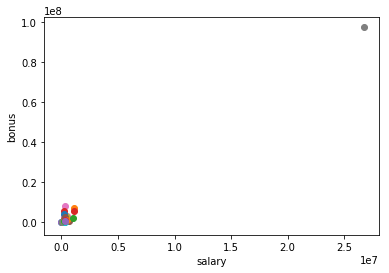

None


In [165]:
print "***************** Before Outlier removal******************************************"
features = ["salary", "bonus"]
data = data_preparation(data_dict,features)
#print data
max_val = outlier_detection(data)
#print max_val


# The above record corresponds to Total line and this needs to be scrubbed

In [166]:
# Remove the Total line from the Data Frame
print enron_df[enron_df.salary == max_val[0]]
#display(enron_df[enron_df.salary == max_val[0]])
# create a new df after reoving the Total line
enron_df = enron_df[enron_df.salary != max_val[0]]
#enron_df = enron_df[enron_df.loc != 'TOTAL']

# Remove the Total line from the data dictionary
# hardcoded the value to remove from the data_dict. I have done this intentionally 
# This was done so as not to remove the Top data point accidentallu for every execution which may remove the POI record
data_dict.pop('TOTAL',0) 


           salary  to_messages  deferral_payments  total_payments  \
TOTAL  26704229.0          NaN         32083396.0     309886585.0   

       exercised_stock_options       bonus  restricted_stock  \
TOTAL              311764000.0  97343619.0       130322299.0   

       shared_receipt_with_poi  restricted_stock_deferred  total_stock_value  \
TOTAL                      NaN                 -7576788.0        434509511.0   

                ...            loan_advances  from_messages       other  \
TOTAL           ...               83925000.0            NaN  42667589.0   

       from_this_person_to_poi    poi  director_fees  deferred_income  \
TOTAL                      NaN  False      1398517.0      -27992891.0   

       long_term_incentive  email_address from_poi_to_this_person  
TOTAL           48521928.0            NaN                     NaN  

[1 rows x 21 columns]


{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

***************** After Outlier removal******************************************
 Max of  salary  is  1111258.0
 Max of  bonus  is  8000000.0


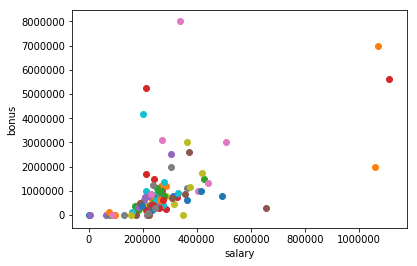

None
[1111258.0, 8000000.0]
                       salary  to_messages  deferral_payments  total_payments  \
SKILLING JEFFREY K  1111258.0       3627.0                NaN       8682716.0   

                    exercised_stock_options      bonus  restricted_stock  \
SKILLING JEFFREY K               19250000.0  5600000.0         6843672.0   

                    shared_receipt_with_poi  restricted_stock_deferred  \
SKILLING JEFFREY K                   2042.0                        NaN   

                    total_stock_value           ...            loan_advances  \
SKILLING JEFFREY K         26093672.0           ...                      NaN   

                    from_messages    other  from_this_person_to_poi   poi  \
SKILLING JEFFREY K          108.0  22122.0                     30.0  True   

                    director_fees  deferred_income  long_term_incentive  \
SKILLING JEFFREY K            NaN              NaN            1920000.0   

                              email_addr

In [167]:
# Double check if there are any other data points that may be skewing the data set unfairly
print "***************** After Outlier removal******************************************"
features = ["salary", "bonus"]
data = data_preparation(data_dict,features)
max_val = outlier_detection(data)
print max_val
print enron_df[enron_df.salary == max_val[0]]
#display(enron_df[enron_df.salary == max_val[0]])

# Inference after Outlier Removal
After the Total line removal, the data set looks good with the new Top Salary corresponding to SKILLING JEFFREY K who is a POI.



# Data Cleansing #2 = Anomaly Detection
There is also Column level aggregation in Total_Payments and Total_Stock_Values  in the dataset. The Payment related fields tallies to the Total_Payment and likewise the stock related fields tallies upto Total_Stock_Values for each Key present in the datapoint (source: the metadata information from enron61702insiderpay.pdf). These fields could be used for validating the accuracy of the data points that is used for the current study

In [168]:
# Additional scrubbing

def detect_anomaly():
    # Create 4 separate list to orgranize 4 groups of data i.e. payment, stock, email and poi
    # Create payment dataframe
    enron_payment_df = enron_df.loc[:,
                                      ['salary','bonus','long_term_incentive',
                                      'deferred_income','deferral_payments','loan_advances',
                                      'other','expenses','director_fees','total_payments']]


    # Create stock dataframe
    enron_stock_df = enron_df.loc[:,
                                      ['exercised_stock_options','restricted_stock','restricted_stock_deferred','total_stock_value']]

    # Creating finance list + poi. The objective is to do a delta from the parent enron_df and extract email related information in a data frame
    enron_finan_list = enron_payment_df.columns.values.tolist() + enron_stock_df.columns.values.tolist() + ["poi"]
    s = set(enron_finan_list)

    # Create email dataframe
    enron_email_list = [x for x in enron_df.columns.values.tolist() if x not in s]
    enron_email_df = enron_df.loc[:,enron_email_list]

    # Rearranging the columns
    enron_email_df = enron_email_df[['email_address','from_messages','to_messages','from_this_person_to_poi','from_poi_to_this_person','shared_receipt_with_poi']]
    
    #Create poi dataframe
    enron_poi_df = enron_df.loc[:,["poi"]] 
    
    print 
    print "*********************************************************************************************************"
    print "Data with values not aligned with the Column level aggregation in Total_Payments and Total_Stock_Values "
    print "*********************************************************************************************************"
    # Validate if the payment & stock data tallies up to their corresponding Columnar total available in the dataset
    #display(enron_payment_df[enron_payment_df.iloc[:,0:9].fillna(0).sum(axis=1) != enron_payment_df.iloc[:,9].fillna(0)])
    #display(enron_stock_df[enron_stock_df.iloc[:,0:3].fillna(0).sum(axis=1) != enron_stock_df.iloc[:,3].fillna(0)])
    print enron_payment_df[enron_payment_df.iloc[:,0:9].fillna(0).sum(axis=1) != enron_payment_df.iloc[:,9].fillna(0)]
    print enron_stock_df[enron_stock_df.iloc[:,0:3].fillna(0).sum(axis=1) != enron_stock_df.iloc[:,3].fillna(0)]
    #print enron_stock_df.iloc[:,0:3].fillna(0)
    #print enron_stock_df.iloc[:,3].fillna(0)

In [169]:
detect_anomaly()


*********************************************************************************************************
Data with values not aligned with the Column level aggregation in Total_Payments and Total_Stock_Values 
*********************************************************************************************************
                  salary  bonus  long_term_incentive  deferred_income  \
BELFER ROBERT        NaN    NaN                  NaN              NaN   
BHATNAGAR SANJAY     NaN    NaN                  NaN              NaN   

                  deferral_payments  loan_advances     other  expenses  \
BELFER ROBERT             -102500.0            NaN       NaN       NaN   
BHATNAGAR SANJAY                NaN            NaN  137864.0       NaN   

                  director_fees  total_payments  
BELFER ROBERT            3285.0        102500.0  
BHATNAGAR SANJAY       137864.0      15456290.0  
                  exercised_stock_options  restricted_stock  \
BELFER ROBERT             

# Clean up Anomaly

The 2 records when further compared to the pdf file source: enron61702insiderpay.pdf), it looks like the values are mismatched. This is likely a data entry error and I will fix them in my dataset

In [170]:
''' 
Fix the anomaly detected above from the Data Frame. 
This data frame will be type casted into data dictionary for the ML alogirthme
'''
# Clean up BELFER ROBERT
enron_df.at['BELFER ROBERT','deferred_income'] = -102500.0
enron_df.at['BELFER ROBERT','deferral_payments'] = np.nan
enron_df.at['BELFER ROBERT','expenses'] = 3285.0
enron_df.at['BELFER ROBERT','director_fees'] = 102500.0
enron_df.at['BELFER ROBERT','total_payments'] = 3285.0

enron_df.at['BELFER ROBERT','exercised_stock_options'] = np.nan
enron_df.at['BELFER ROBERT','restricted_stock'] = 44093.0
enron_df.at['BELFER ROBERT','restricted_stock_deferred'] =-44093.0
enron_df.at['BELFER ROBERT','total_stock_value'] = np.nan

enron_df.loc['BELFER ROBERT']

# Clean up BHATNAGAR SANJAY

enron_df.at['BHATNAGAR SANJAY','other'] = np.nan
enron_df.at['BHATNAGAR SANJAY','expenses'] = 137864.0
enron_df.at['BHATNAGAR SANJAY','director_fees'] = np.nan
enron_df.at['BHATNAGAR SANJAY','total_payments'] = 137864.0

enron_df.at['BHATNAGAR SANJAY','exercised_stock_options'] = 15456290.0
enron_df.at['BHATNAGAR SANJAY','restricted_stock'] = 2604490.0
enron_df.at['BHATNAGAR SANJAY','restricted_stock_deferred'] =-2604490.0
enron_df.at['BHATNAGAR SANJAY','total_stock_value'] = 15456290.0


In [171]:
# Check now to see if the anomalies are addressed
detect_anomaly()


*********************************************************************************************************
Data with values not aligned with the Column level aggregation in Total_Payments and Total_Stock_Values 
*********************************************************************************************************
Empty DataFrame
Columns: [salary, bonus, long_term_incentive, deferred_income, deferral_payments, loan_advances, other, expenses, director_fees, total_payments]
Index: []
Empty DataFrame
Columns: [exercised_stock_options, restricted_stock, restricted_stock_deferred, total_stock_value]
Index: []


# Data Cleansing #3 = Missing Value Detection

In [172]:
# Validate if there are any records with lots of NULL values that may not be useful
print
print "*********************************************************************************************************"
print "Validate the # of columns with NULL values for each record / key "
print "*********************************************************************************************************"

print enron_df.isnull().sum(axis=1).sort_values(ascending=False)
print enron_df.loc[['LOCKHART EUGENE E','WROBEL BRUCE','WHALEY DAVID A','GRAMM WENDY L','THE TRAVEL AGENCY IN THE PARK']]

# LOCKHART EUGENE E has all of the financial and email related columns as NULL and furthere he is a non poi and hence could be scrubbed from the study
try:
    enron_df = enron_df.drop('LOCKHART EUGENE E')
except ValueError:
    pass    


*********************************************************************************************************
Validate the # of columns with NULL values for each record / key 
*********************************************************************************************************
LOCKHART EUGENE E                20
WROBEL BRUCE                     18
WHALEY DAVID A                   18
GRAMM WENDY L                    18
THE TRAVEL AGENCY IN THE PARK    18
GILLIS JOHN                      17
WODRASKA JOHN                    17
SAVAGE FRANK                     17
SCRIMSHAW MATTHEW                17
CLINE KENNETH W                  17
WAKEHAM JOHN                     17
CHAN RONNIE                      16
MENDELSOHN JOHN                  16
PEREIRA PAULO V. FERRAZ          16
BLAKE JR. NORMAN P               16
YEAP SOON                        16
GATHMANN WILLIAM D               16
URQUHART JOHN A                  16
FUGH JOHN L                      16
LOWRY CHARLES P                  16
M

# 2) Feature Selection 

a) My plan is to initially use all the features (except the email address) as is and build 3 models based on GaussianNB, Decision Tree Classifier and KMeans respectively and to arrive at the evaluation. This will server as the baseline for performance of the algorithm.

b) The next step would be to engineer new features and to determine K Best features based on their relevance to the output labels that are to be predicted.

c) The third and final step is to pick the better performing algorithm from above steps and tuning the hyperparameters to improve the results as needed.



# 2a) Feature Selection - Performance Baseline
The idea is to use all of the existing features except email and determine the performance to serve as a baseline.

In [201]:
features_list_org_all = ['poi','salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus',
 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses',
 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person']

In [202]:
# Replacing the numpy.nan to 'NaN' as the feature format function scrubs the NaN (string) from the numerical field 
# handled in the following funtion -> featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
enron_df = enron_df.replace(np.nan,'NaN')
my_dataset = enron_df.to_dict('index')

# Resetting the 'Nan' back to numpy.nan in enron_df
enron_df = enron_df.replace('NaN', np.nan)


In [203]:
print 
print "*********************************************************************************************************"
print "Model Evaluation - Baseline Performance before any New engineered features / Feature Selection / Tuning"
print "*********************************************************************************************************"

#data = featureFormat(my_dataset, features_list, sort_keys = True)
#labels, features = targetFeatureSplit(data)


# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list_org_all)
tester.main();

print "*********************************************************************************************************"

# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list_org_all)
tester.main();

print "*********************************************************************************************************"

# Create and test the K Means clustering classifier
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list_org_all)
tester.main();

print "*********************************************************************************************************"


*********************************************************************************************************
Model Evaluation - Baseline Performance before any New engineered features / Feature Selection / Tuning
*********************************************************************************************************
GaussianNB(priors=None)
	Accuracy: 0.76980	Precision: 0.25448	Recall: 0.37650	F1: 0.30369	F2: 0.34355
	Total predictions: 15000	True positives:  753	False positives: 2206	False negatives: 1247	True negatives: 10794

*********************************************************************************************************
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 

# 2b) Feature Selection - Engineer new Features:
The choice of new features are 
(a) ratio of financial earnings (total earning, payments, stock) as they may be good indicator for identifying POI
(b) ratio of email exchanges that the employee had with the POI. The thought process is that POI is more tightly knit group and may have had frequent email correspondences with each other.


In [204]:
# Calculate the below 5 features:

enron_df['ratio_of_total_earning']=(enron_df['total_payments'].fillna(0)+ enron_df['total_stock_value'] .fillna(0))/enron_df ['total_payments'].fillna(0.0).sum() + enron_df ['total_stock_value'].fillna(0.0).sum()
enron_df['ratio_of_total_payments']=enron_df['total_payments'].fillna(0) /enron_df ['total_payments'].fillna(0.0).sum()
enron_df['ratio_of_total_stock']=enron_df['total_stock_value'].fillna(0)/ enron_df ['total_stock_value'].fillna(0.0).sum()
enron_df['ratio_from_poi'] = enron_df['from_poi_to_this_person'] / enron_df['to_messages']
enron_df['ratio_to_poi'] = enron_df['from_this_person_to_poi'] / enron_df['from_messages']


In [205]:
features_list_eng_all = ['poi','salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus',
 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses',
 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person',
 'ratio_of_total_earning',
 'ratio_of_total_payments',
 'ratio_of_total_stock',
 'ratio_from_poi','ratio_to_poi']

In [206]:
# reset the nan to 'Nan' before converting the df to dict

enron_df = enron_df.replace(np.nan,'NaN')
my_dataset = enron_df.to_dict('index')

# 2c) Feature Selection - SelectKBest

I intend to use SelectKBestselection function. SelectKBest works by selecting the Top K features that have maximum influence on the target variable. It takes 2 inputs i.e. features and lables and takes the K features and evaluates the relevance of every feature using the score function.

In [230]:

data = featureFormat(my_dataset, features_list_eng_all, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Perform feature selection
selector = SelectKBest(f_classif, k='all')
selector.fit(features, labels)
kbest_scores = sorted(zip(selector.scores_, features_list_eng_all[1:]), reverse=True)

# picking Top 12 features for the ML alogorithm:

POI_label = ['poi']
#features_list_all = features_list
features_list_kbest= POI_label + [(i[1]) for i in kbest_scores[0:10]]

print "*********************************************************************************************************"
print "Feature Selection with Engineered Features"
print "*********************************************************************************************************"

print
print 'Total list of Features',features_list_eng_all

print
print 'SelectKBest scores: ', kbest_scores[0:10]
print
print 'KBest Features',features_list_kbest


*********************************************************************************************************
Feature Selection with Engineered Features
*********************************************************************************************************

Total list of Features ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'ratio_of_total_earning', 'ratio_of_total_payments', 'ratio_of_total_stock', 'ratio_from_poi', 'ratio_to_poi']

SelectKBest scores:  [(22.78210782973431, 'total_stock_value'), (22.782107829734304, 'ratio_of_total_stock'), (22.61053070687377, 'exercised_stock_options'), (21.06000170753657, 'bonus'), (18.575703268041785, 'salary'), (16.641707070468

# 2d) Feature Engineering & Feature selection using KBest Features - Performance

In [217]:

print 
print "*********************************************************************************************************"
print "Model Evaluation - Performance with new engineered features / Feature Selection - Before any Tuning"
print "*********************************************************************************************************"


print "*********************************************************************************************************"

# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list_kbest)
tester.main();

print "*********************************************************************************************************"

# Create and test the K Means clustering classifier
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list_kbest)
tester.main();

# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list_kbest)
tester.main();



*********************************************************************************************************
Model Evaluation - Performance with new engineered features / Feature Selection - Before any Tuning
*********************************************************************************************************
*********************************************************************************************************
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.80680	Precision: 0.28033	Recall: 0.28650	F1: 0.28338	F2: 0.28524
	Total predictions: 15000	True positives:  573	False positives: 1471	False negatives: 1427	True negatives: 11529

***************************************

#  2) Feature Selection - Observations: 
By comparing the above results with the baseline performance below are the observations:
1) Gaussian NB is clearly performing better 
2) Newly engineered features helped the classifier performance
3) Also, selecting the K best festures and using them for the classification improved the F1 score in comparison to the baseline model evaluation.
Kmeans model evaluated the least and hence I am proceeding with the GaussianNB and DecistionTreeClassifier based models and tune them further to arrive at a final model		


# 3) Feature Scaling & Algorithm Selection:
Although the dataset consists of wide range of values particularly the financial data, featue scaling is more relevant to the algorithm such as Kmeans that use the Eucledian distance between two data point. For the algorithm that I chose to implement i.e. the Gaussian NB and DecisionTree Classifer this would not have much impact. Nonetheless, I am implementing Min Max feature scaling as I am looking to determine if this makes any difference to the evaluation metrics of the algorithm that I have chosen.

# 4) Parameter Tuning & Validation:

<U> Tuning:</U>
Parameter tuning essentially is the process to maximize the models performance while striking a balanace between  overfitting and high variance.The tuning of the hyperparameters could be achieved in a manual way or in an automated manner. I chose the GridSearchCV route to tune the models that I had chosen based on the resuls from Feature Selection. The algorithm are namely: DecisionTreeClassifier and GaussianNB

The essential idea is to contruct a pipleline of Scaler (MinMaxScaler()), PCA and Hyperparameters grid (in case of DecisionTreeClassifier) to tune different combinations of the models.

<U> Validation:</U>
Validation is necessary to ensure that the developed model is just as useful and applicable to the "real world data" not just with the data that was used to train the algorithm. For the current problem at hand, the data points is relatively a smaller set, thereyby it is beneficial to iteratively draw and split the test/train data and valdiate the model against the several folds of the data. This makes the StratifiedShuffleSplit a suitable validation strategy.

I have used the startup code utility i.e. tester.test_classifier that was provided by udacity towards this putpose of evaluating the metrics. For my analysis purpose, i had reused the code from tester.test_classifier and created a local function called ptest_classifier The only change that I had done to the ptest_classifer function is to reduce the folds from 1000 to 10 to tradeoff execution time and speed.

# 5) Evaluation Metrics:

Here the problem at hand is to classify or categorize based on the features if the employee in the dataset is a POI or a non POI. From the underlying data we have  POI =  18 & non-POI =  128. The observations are imbalanced. Hence for the model to accurately label a non-POI as non POI is not particularly useful as it a likely occurence. This rules out the Accuracy metric unsuitable for a the imbalanced classes such as our problem here.


Precision is the ratio of total number of True Positive to the total number of True Positive + False Postives. This answers the question - if the algorithm predicts a person as POI, how likely that the person is really a POI.

while Recall is the ratio of total number of True Positive to the total number of True Positive + False Negative. This answers the question - how many times the algorithm identified a POI correctly,  provided that the person is indeed a POI

Precision and Recall are more insightful to our classification here as the measure of high accuracy of Non-Poi is not really helpful. Instead, the ability to classify a POI as a POI is more meaningful.

For evaluating of my algorithm, I am going with the F1 score which is the harmonic measure of precision and recall and is mathematically computed as 
2 * ( ( precision * recall) / (precision + recall) )



In [191]:
""" This function is based on tester.test_classifier that is provided as a part of start up code. 
The only change I have done here is to keep the folds to 10 rather than 1000 to trade off the execution time"""

def ptest_classifier(clf, dataset, feature_list, folds = 1000):

    import sys
    from sklearn.cross_validation import StratifiedShuffleSplit
    sys.path.append("../tools/")
    from feature_format import featureFormat, targetFeatureSplit
    PERF_FORMAT_STRING = "\
    \tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
    Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
    RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
    \tFalse negatives: {:4d}\tTrue negatives: {:4d}"

    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    #  class sklearn.cross_validation.StratifiedShuffleSplit
    # (y, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)

    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
 
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
        #print '*******************************'
        #print clf.best_estimator_.feature_importances_
        #print '*******************************'        
        
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

# Performance Tuning and Validation of GaussianNB model with PCA

In [210]:
print 
print "*********************************************************************************************************************************"
print "Model Evaluation - Performance with new engineered features / Feature Selection / Tuning using StratifiedShuffleSplit"
print "*********************************************************************************************************************************"


print "GaussianNB Model Evaluation - with MinMaxScaler,SelectKBest & PCA using StratifiedShuffleSplit"

pipe = Pipeline([
        ('scaler', preprocessing.MinMaxScaler()),
        ('selector', SelectKBest()),
        ('reducer', PCA(random_state=42)),
        ('classifier', GaussianNB())
    ])

param_grid = {
    'scaler': [None, preprocessing.MinMaxScaler()],
    'selector__k': [10, 15, 'all'],
    'reducer__n_components': [1,2,6,10]
}

clf_gnb_grd = GridSearchCV(pipe, param_grid, scoring='f1')
#ptest_classifier(clf_gnb_grd, my_dataset, features_list_all)
tester.dump_classifier_and_data(clf_gnb_grd, my_dataset, features_list_eng_all)
tester.main();



*********************************************************************************************************************************
Model Evaluation - Performance with new engineered features / Feature Selection / Tuning using StratifiedShuffleSplit
*********************************************************************************************************************************
GaussianNB Model Evaluation - with MinMaxScaler,SelectKBest & PCA using StratifiedShuffleSplit
GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x000000001A08E6D8>)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reducer__n_components': [1, 2, 6, 10], 'selector

# Performance Tuning and Validation of GaussianNB model without PCA

In [221]:
print "*********************************************************************************************************************************"
print "GaussianNB Model Evaluation - with MinMaxScaler,SelectKBest & without PCA using StratifiedShuffleSplit"
print "*********************************************************************************************************************************"

pipe = Pipeline([
        ('scaler', preprocessing.MinMaxScaler()),
        ("selector", SelectKBest()),
        ('classifier', GaussianNB())
    ])

param_grid = {
    'scaler': [None, preprocessing.MinMaxScaler()],
    'selector__k': [10, 15, 'all']
}

clf_gnb_grd = GridSearchCV(pipe, param_grid, scoring='f1')
#ptest_classifier(clf_gnb_grd, my_dataset, features_list_all)
tester.dump_classifier_and_data(clf_gnb_grd, my_dataset, features_list_eng_all)
tester.main();

## Features and the Feature score of the final model
print 
print "*********************************************************************************************************************************"
print "GaussianNB parameters"
print clf_gnb_grd.get_params()
print "*********************************************************************************************************************************"

'''
print
print "*********************************************************************************************************************************"
print "Features and the Feature score of the final model" 
gt_kbest_scores = sorted(zip(selector.scores_, features_list_eng_all[:10]), reverse=True)
print gt_kbest_scores
print "*********************************************************************************************************************************"

'''



*********************************************************************************************************************************
GaussianNB Model Evaluation - with MinMaxScaler,SelectKBest & without PCA using StratifiedShuffleSplit
*********************************************************************************************************************************
GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x000000001A08E6D8>)), ('classifier', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'selector__k': [10, 15, 'all'], 'scaler': [None, MinMaxScaler(copy=True, feature_range=(0, 1))]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)
	Accuracy: 0.81087	Precision: 0.30544	Recall: 0.32850	F1: 0.31655	F2: 0.32361
	Total predictions: 15000	True positives:  657	

'\nprint\nprint "*********************************************************************************************************************************"\nprint "Features and the Feature score of the final model" \ngt_kbest_scores = sorted(zip(selector.scores_, features_list_eng_all[:10]), reverse=True)\nprint gt_kbest_scores\nprint "*********************************************************************************************************************************"\n\n'

# Performance Tuning and Validation of DecisionTree model

In [213]:
print "*********************************************************************************************************************************"
print "DecisionTreeClassifier Model Evaluation - with MinMaxScaler,SelectKBest & PCA using StratifiedShuffleSplit"
print "*********************************************************************************************************************************"

CRITERION = ['gini', 'entropy']
SPLITTER = ['best', 'random']
MIN_SAMPLES_SPLIT = [2, 4, 6, 8]
CLASS_WEIGHT = ['balanced', None]


pipe = Pipeline([
        ('scaler', preprocessing.MinMaxScaler()),
        ("selector", SelectKBest()),
        ('reducer', PCA(random_state=42)),
        ('classifier', DecisionTreeClassifier())
    ])

param_grid = {
    'scaler': [None, preprocessing.MinMaxScaler()],
    'selector__k': [10, 15, 'all'],
    'reducer__n_components': [1,2,6,10],
    'classifier__criterion': CRITERION,
    'classifier__splitter': SPLITTER,
    'classifier__min_samples_split': MIN_SAMPLES_SPLIT,
    'classifier__class_weight': CLASS_WEIGHT,
}

clf_dt_grd = GridSearchCV(pipe, param_grid, scoring='f1').fit(features, labels).best_estimator_
# ptest_classifier(clf_dt_grd, my_dataset, features_list_eng_all)

tester.dump_classifier_and_data(clf_dt_grd, my_dataset, features_list_eng_all)
tester.main();

'''
print
print "*********************************************************************************************************************************"
print "Features and the Feature score of the final model" 
print "*********************************************************************************************************************************"
dt_features_list_imp = features_list_eng_all[1:]
feature_scores = sorted({dt_features_list_imp[i]:clf_dt_grd.get_params()['selector'].scores_[i]
                         for i in range(0,len(dt_features_list_imp))}.items(), reverse=True, key=operator.itemgetter(1))
print feature_scores
'''

*********************************************************************************************************************************
DecisionTreeClassifier Model Evaluation - with MinMaxScaler,SelectKBest & PCA using StratifiedShuffleSplit
*********************************************************************************************************************************
Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=15, score_func=<function f_classif at 0x000000001A08E6D8>)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=6, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', De...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
	Accuracy: 0.79673	Precision: 0.22056	Recall: 0.20700	F1: 0.21357	F2: 0.20958
	Total predictions: 15000	True positives:  414	False positives: 1463	False negatives: 1586	True negatives: 11537


********

#  <p style="background-color: #355667"> <font color = 'white'> Final Model </font> </p>

In [234]:
# setting the CLF, my_dataset,feature_list for easy dump and testing


clf = GaussianNB()
my_dataset = my_dataset
features_list = features_list_kbest

tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

print
print 'SelectKBest scores: ', kbest_scores[0:10]
print
print 'KBest Features',features_list_kbest


GaussianNB(priors=None)
	Accuracy: 0.85487	Precision: 0.44212	Recall: 0.33800	F1: 0.38311	F2: 0.35471
	Total predictions: 15000	True positives:  676	False positives:  853	False negatives: 1324	True negatives: 12147


SelectKBest scores:  [(22.78210782973431, 'total_stock_value'), (22.782107829734304, 'ratio_of_total_stock'), (22.61053070687377, 'exercised_stock_options'), (21.06000170753657, 'bonus'), (18.575703268041785, 'salary'), (16.64170707046899, 'ratio_to_poi'), (11.561887713503024, 'deferred_income'), (10.072454529369441, 'long_term_incentive'), (9.380236796811587, 'total_payments'), (9.380236796811587, 'ratio_of_total_payments')]

KBest Features ['poi', 'total_stock_value', 'ratio_of_total_stock', 'exercised_stock_options', 'bonus', 'salary', 'ratio_to_poi', 'deferred_income', 'long_term_incentive', 'total_payments', 'ratio_of_total_payments']


# 6) Conclusion:

Based on the above results, GaussianNB outperformed the DecisionTreeClassifier. The comparison of results from <b> GaussianNB model </b> at different stages is summarized below for perusal:

<p style="background-color: green"> <font color = 'white'> <b>Performance with new engineered features & SelectKBest Feature Selection (Final Model) is: </b></font> </p>

<b>
Precision = 44.21%
Recall = 33.80%
F1 = 38.31%
</b>

<p style="background-color: maroon"> <font color = 'white'> <b>Baseline Performance with inherent features (no engineered features:) </b></font> </p>

<b>
Precision = 25.45%
Recall = 37.65%
F1 = 30.37%
</b>


<p style="background-color: maroon"> <font color = 'white'> <b>Performance of the model after Tuning: </b></font> </p>

<b> Without PCA reduction
Precision = 30.54%
Recall = 32.85%
F1 = 31.65%
</b>

<b> With PCA reduction
Precision = 36.72%
Recall = 25.10%
F1 = 29.82%
</b>
<p>
The Features that were used in the final model are listed below:


Features and the Feature score of the final model <br>
[(22.78210782973431, 'total_stock_value'), <br>
(22.782107829734304, 'ratio_of_total_stock'), <br>
(22.61053070687377, 'exercised_stock_options'),<br>
(21.06000170753657, 'bonus'), <br>
(18.575703268041785, 'salary'),<br>
(16.64170707046899, 'ratio_to_poi'),<br>
(11.561887713503024, 'deferred_income'),<br>
(10.072454529369441, 'long_term_incentive'),<br>
(9.380236796811587, 'total_payments'),<br>
(9.380236796811587, 'ratio_of_total_payments')]<br>


As excpect the Scaler and PCA did not improve the metrics in the case of GaussianNB and hence my final model did not use them. Interestingly in this case, when Feature Scaling and PCA was applied to the features the F1 score decreased thereby indicating that it led to information loss which the GaussianNB benefitted from.<br>

What does the Precision and Recall from the final model mean? A recall of 34% implies that when the person is indeed a POI, the classifier will detect the same 34 out of 100 instances. This is not ideal in the real world scenario. It is important important to note though that it is likely that we could enhance the metric further if further features are made available to the model. This is something that I could further explore to augment my Machine learning skills :)



<img src="C:\Users\ss842p\Documents\ATT Sab Documents\Nano Degree\Data Analyst\Machine Learning\ud120-projects-master\ud120-projects-master\final_project\summary.jpeg">